# tension_time_evolution

> Evolve tension in time

Simulate time evolution of tension triangulation, so far without reference to real space. Ensure flatness at every step using fake energy minimization.

See lattice model simulation notebooks.

In [ ]:
#| default_exp tension

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| hide
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial

from tqdm.notebook import tqdm

In [ ]:
#| hide

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

## Time evolution in a single triangle

In [ ]:
#| export

# basic formulas for triangles

def vectors_angle(a,b):
    """Angle between two vectors"""
    inner = (a@b)/sqrt((a@a)*(b@b))
    return arccos(inner)

def sides_area(Ts):
    """Triangle area from side lengths"""
    Ts = np.sort(Ts, axis=0)[::-1]
    #A = sqrt((Ts[0]+Ts[1]+Ts[2])*(-Ts[0]+Ts[1]+Ts[2])*(Ts[0]-Ts[1]+Ts[2])*(Ts[0]+Ts[1]-Ts[2]))/4
    A = (Ts[0]+(Ts[1]+Ts[2]))*(Ts[2]-(Ts[0]-Ts[1]))*(Ts[2]+(Ts[0]-Ts[1]))*(Ts[0]+(Ts[1]-Ts[2]))/16
    return sqrt(np.clip(A, 0, np.inf))

def sides_circum(Ts):
    """Triangle circumcircle from side lengths"""
    R = np.prod(Ts, axis=0)/(4*sides_area(Ts))
    return R

def sides_angles(Ts):
    """Triangle angles from side lengths. Sorted so that angle [i] is opposite to Ts[i]"""
    R = sides_circum(Ts)
    inds = np.argmax(Ts, axis=0)
    # need to take the smaller two angles so as to avoid error in arcsin for angles >90
    phis = np.arcsin(Ts/(2*R))
    if isinstance(inds, np.ndarray):
        phis[inds, np.arange(len(inds))] = pi-(phis.sum(axis=0)-phis[inds, np.arange(len(inds))])
    else:
        phis[inds] =  pi-(phis.sum(axis=0)-phis[inds])
    return phis

def angles_shape(phis):
    """Shape order parameter from angles"""
    alpha, beta, gamma = phis
    x = sqrt(3)*sin(alpha)*sin(alpha+2*beta)
    y = (cos(alpha)*cos(alpha+2*beta) - cos(2*alpha))
    psi = np.arctan2(x, y) + pi

    Psi = 6+2*(cos(4*triangle)-cos(2*triangle) - cos(2*(triangle-np.roll(triangle, 1, axis=0)))).sum(axis=0)
    Psi /= (3-cos(2*triangle).sum(axis=0))**2
    Psi = np.sqrt(Psi)
    
    psi_tilde = pi - np.abs((3*psi) % (2*pi) - pi)
    
    return np.array([psi_tilde, Psi])

In [ ]:
round(sides_area([1, 1, sqrt(2)]), ndigits=3) == 1/2

True

In [ ]:
round(sides_circum([sqrt(3), sqrt(3), sqrt(3)]), ndigits=3) == 1

True

In [ ]:
np.round(sides_angles(np.array([1, 1, 1]))*180/pi) == 60

array([ True,  True,  True])

In [ ]:
#| export
def sides_area_jac(Ts):
    """get jacobian of area change in edge length"""
    dA = np.array([0., 0., 0.])
    #inds = np.argsort(-Ts, axis=0)
    #Ts = np.take_along_axis(Ts, inds, axis=0)
    dA += np.array([1, 1, 1])   * (Ts[2]-(Ts[0]-Ts[1])) * (Ts[2]+(Ts[0]-Ts[1])) * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * np.array([-1, 1, 1])  * (Ts[2]+(Ts[0]-Ts[1])) * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * (Ts[2]-(Ts[0]-Ts[1])) * np.array([1, -1, 1])  * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * (Ts[2]-(Ts[0]-Ts[1])) * (Ts[2]+(Ts[0]-Ts[1])) * np.array([1, 1, -1])

    dA /= 48*(sides_area(Ts)+1e-5)
    #dA = np.take_along_axis(dA, inds, axis=0)
    return dA

In [ ]:
Ts = np.array([.7, 1.3, sqrt(2)])
dTs = np.array([.2, -.2, -.05])

areas = [round(x, ndigits=2)
         for x in [sides_area(Ts), sides_area(Ts+dTs), sides_area(Ts)+sides_area_jac(Ts).dot(dTs)]]

print(areas)
assert areas[1] == areas[2]  # to reasonable precision

[0.45, 0.49, 0.49]


In [ ]:
#| export

# tension time evolution in triangle with constrained area
def excitable_dt(Ts, m=2):
    """Time derivative of tensions under excitable tension model with constrained area"""
    dT_dt = Ts**m
    area_jac = sides_area_jac(Ts)
    area_jac /= norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)
    return dT_dt

In [ ]:
Ts = np.array([.7, 1.3, sqrt(2)])
dt = .02
dTs = excitable_dt(Ts) * dt

areas = [round(x, ndigits=2) for x in [sides_area(Ts), sides_area(Ts+dTs)]]
print(areas)
assert areas[0] == areas[1]  # to reasonable precision, areas don't change

[0.45, 0.45]


In [ ]:
def excitable_dt_angles(phi_is, m=2):
    """Time derivative of angles under excitable tension model with constrained circumcircle"""
    # convert to angles
    Ti_rate = sin(phi_is)**(m-1)
    second_term = (Ti_rate * tan(phi_is)).sum() / tan(phi_is).sum()
    phi_is_dot = tan(phi_is) * (Ti_rate  - second_term)
    return phi_is_dot

## To Do:

- add `rest` (length) and `flipped` attributes to the `HalfEdge` class, 
- remove Edge class? Not really required if we simulate based on half edges
- add method to compute lengths, angles of `HalfEdges` in `HalfEdgeMesh`

## ODE integrator

Need to make my own little ODE solver because between ODE steps, we will need to find the real space tessellation. 

Se Numerical Recipes Chpt. 17. 

In [ ]:
## scipy ODE solver for some triangle

y0 = np.array([sqrt(2), 1.2, 1])
A0 = sides_area(y0)

rhs = lambda t, y: excitable_dt(y, m=2)

t = np.linspace(0, .7, 100)

sol = solve_ivp(rhs, (t[0], t[-1]), y0,  t_eval=t, method="RK45", rtol=1e-4,)
print(sol["message"])
sol = sol["y"]
As = sides_area(sol)
angles = sides_angles(sol) * (180/pi)

The solver successfully reached the end of the integration interval.


(0.0, 2.0)

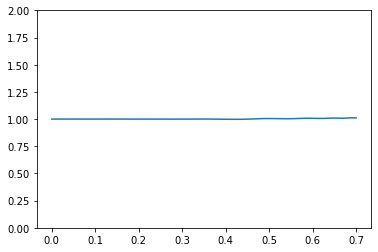

In [ ]:
plt.plot(t, As/A0)
plt.ylim([0, 2])

[<matplotlib.lines.Line2D>]

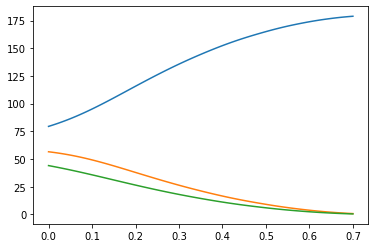

In [ ]:
plt.plot(t, angles[0])
plt.plot(t, angles[1])
plt.plot(t, angles[2])

[<matplotlib.lines.Line2D>]

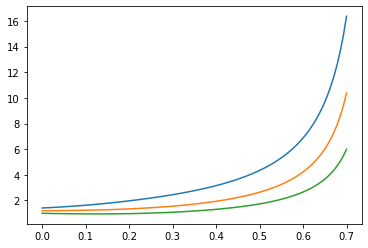

In [ ]:
plt.plot(t, sol[0])
plt.plot(t, sol[1])
plt.plot(t, sol[2])

In [ ]:
## naive Euler stepping - looks ok!

Ts = [y0,]
ts = [0,]

dt = .01

for i in range(70):
    ts.append(ts[-1]+dt)
    T_new = Ts[-1]+dt*excitable_dt(Ts[-1], m=2)
    Ts.append(T_new)
Ts = np.stack(Ts, axis=-1)
ts = np.array(ts)

[<matplotlib.lines.Line2D>]

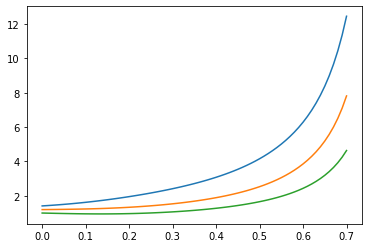

In [ ]:
plt.plot(ts, Ts[0])
plt.plot(ts, Ts[1])
plt.plot(ts, Ts[2])

## Create a test Half edge mesh and add a method to calculate internal angles

## Export code

In [ ]:
#| hide
nbdev.nbdev_export()